In [2]:
# Required libraries
!pip install scikit-posthocs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as stats
import seaborn as sns
import string
import scikit_posthocs as sp
import statsmodels.api as sm
import arviz as az

# Required partial libraries
from sklearn.metrics import confusion_matrix, classification_report
from scipy.optimize import minimize_scalar
from sklearn.metrics import accuracy_score
from scipy.stats import norm
from sklearn.utils import shuffle
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from scipy.stats import pearsonr
from matplotlib.colors import LinearSegmentedColormap
from scipy import interpolate
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests

In [4]:
# Checking model accuracy for SynEARs only with EAR motifs for reviewer 2
SynEAR_subset = pd.read_csv('/content/SynEAR dataset with only EAR motif for reviewer 2 - Supplemental Table 3.csv', skiprows=1)

SynEAR = SynEAR_subset


In [9]:
# Subset model predictions

# Helper function to ensure numeric data
def ensure_numeric(series):
    return pd.to_numeric(series, errors='coerce')

# Choosing optimal thresholds

def find_optimal_thresholds(data, true_labels):
    # Ensure the data is numeric
    clean_data = ensure_numeric(data).dropna()

    # Setup initial guesses based on quartiles to ensure they are spread appropriately
    initial_thresholds = sorted(np.percentile(clean_data, [25, 50, 75]))

    # Function to categorize values based on thresholds
    def categorize_values(thresholds):
        categories = pd.cut(clean_data, bins=[-np.inf] + list(thresholds) + [np.inf], labels=["weak", "moderate", "strong", "strongest"])
        return categories

    # Calculate negative accuracy
    def calc_neg_accuracy(thresholds):
        labels_pred = categorize_values(thresholds)
        return -accuracy_score(true_labels.loc[clean_data.index], labels_pred)  # Match indices after dropna()

    # Sequential threshold optimization
    def optimize_thresholds(init_thresholds):
        optimized_thresholds = init_thresholds[:]
        for i in range(len(init_thresholds)):
            lower_bound = optimized_thresholds[i-1] if i > 0 else clean_data.min()
            upper_bound = optimized_thresholds[i+1] if i < (len(init_thresholds)-1) else clean_data.max()
            if lower_bound < upper_bound:  # Ensure valid bounds
                result = minimize_scalar(lambda x: calc_neg_accuracy(optimized_thresholds[:i] + [x] + optimized_thresholds[i+1:]),
                                         bounds=(lower_bound, upper_bound),
                                         method='bounded')
                if result.success:
                    optimized_thresholds[i] = result.x
                else:
                    raise Exception(f"Optimization failed at index {i} with bounds ({lower_bound}, {upper_bound})")
            else:
                raise ValueError(f"Invalid bounds [{lower_bound}, {upper_bound}] at index {i}")
        return optimized_thresholds

    return optimize_thresholds(initial_thresholds)

# Converting columns to numeric upfront
SynEAR_model['green_blanked'] = ensure_numeric(SynEAR_model['green_blanked'])
SynEAR_model['red_blanked'] = ensure_numeric(SynEAR_model['red_blanked'])
SynEAR_model['green_red_ratio'] = ensure_numeric(SynEAR_model['green_red_ratio'])
SynEAR_model['repression_ratio'] = ensure_numeric(SynEAR_model['repression_ratio'])
SynEAR_model['invert_rep_ratio'] = ensure_numeric(SynEAR_model['invert_rep_ratio'])

# Defining thresholds
optimal_green_thresholds = find_optimal_thresholds(SynEAR_model['green_blanked'], SynEAR_model['strength_class'])
print("Optimal green thresholds:", optimal_green_thresholds)

optimal_red_thresholds = find_optimal_thresholds(SynEAR_model['red_blanked'], SynEAR_model['strength_class'])
print("Optimal red thresholds:", optimal_red_thresholds)

optimal_ratio_thresholds = find_optimal_thresholds(SynEAR_model['green_red_ratio'], SynEAR_model['strength_class'])
print("Optimal ratio thresholds:", optimal_ratio_thresholds)

optimal_rep_ratio_thresholds = find_optimal_thresholds(SynEAR_model['repression_ratio'], SynEAR_model['strength_class'])
print("Optimal repression ratio thresholds:", optimal_rep_ratio_thresholds)

optimal_invert_rep_ratio_thresholds = find_optimal_thresholds(SynEAR_model['invert_rep_ratio'], SynEAR_model['strength_class'])
print("Optimal invert rep ratio thresholds:", optimal_invert_rep_ratio_thresholds)

<ipython-input-9-e02cbb05a3c9>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SynEAR_model['green_blanked'] = ensure_numeric(SynEAR_model['green_blanked'])
<ipython-input-9-e02cbb05a3c9>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SynEAR_model['red_blanked'] = ensure_numeric(SynEAR_model['red_blanked'])
<ipython-input-9-e02cbb05a3c9>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Optimal green thresholds: [1297.1178564421682, 10133.692411687773, 13822.79956482106]
Optimal red thresholds: [222.82059149499793, 995.5433025596426, 3905.249920237194]
Optimal ratio thresholds: [2.8195714856180882, 11.143337378744015, 17.931204111360465]
Optimal repression ratio thresholds: [0.12377480398500987, 1.081892769963419, 1.4724517184441814]
Optimal invert rep ratio thresholds: [0.4475024766026672, 2.0243681199639965, 5.464535459242741]


In [10]:
# Subset confusion matrix generation


def categorize_strength(value, thresholds):
    if value < thresholds[0]:
        return 'weak'
    elif value < thresholds[1]:
        return 'moderate'
    elif value < thresholds[2]:
        return 'strong'
    else:
        return 'strongest'

# Define your thresholds
thresholds_green = optimal_green_thresholds # optimized thresholds green
thresholds_red = [259.55034738498324, 552.3413705935939, 2610.8294611250267] # optimized thresholds for red
thresholds_ratio = [6.181297361281594, 14.254757509316702, 36.15600566570992] # Example thresholds

thresholds_rep_ratio = [0.5189876661959548, 0.9319474928721667, 3.225354932770726]
thresholds_invert_rep_ratio = [0.37118340050355275, 1.3350420378043253, 6.890773084136302]

# Apply the categorization to your measurements columns
SynEAR_model['green_category'] = SynEAR_model['green_blanked'].apply(lambda x: categorize_strength(x, thresholds_green))
SynEAR_model['red_category'] = SynEAR_model['red_blanked'].apply(lambda x: categorize_strength(x, thresholds_red))
SynEAR_model['ratio_category'] = SynEAR_model['green_red_ratio'].apply(lambda x: categorize_strength(x, thresholds_ratio))
SynEAR_model['rep_ratio_category'] = SynEAR_model['repression_ratio'].apply(lambda x: categorize_strength(x, thresholds_ratio))
SynEAR_model['invert_rep_ratio_category'] = SynEAR_model['invert_rep_ratio'].apply(lambda x: categorize_strength(x, thresholds_ratio))

<ipython-input-10-e0736581f018>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SynEAR_model['green_category'] = SynEAR_model['green_blanked'].apply(lambda x: categorize_strength(x, thresholds_green))
<ipython-input-10-e0736581f018>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SynEAR_model['red_category'] = SynEAR_model['red_blanked'].apply(lambda x: categorize_strength(x, thresholds_red))
<ipython-input-10-e0736581f018>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

Classification Report for green_category:
              precision    recall  f1-score   support

        weak       0.00      0.00      0.00         4
    moderate       0.38      0.75      0.50        36
      strong       0.46      0.22      0.30        27
   strongest       0.52      0.24      0.33        46

    accuracy                           0.39       113
   macro avg       0.34      0.30      0.28       113
weighted avg       0.44      0.39      0.36       113



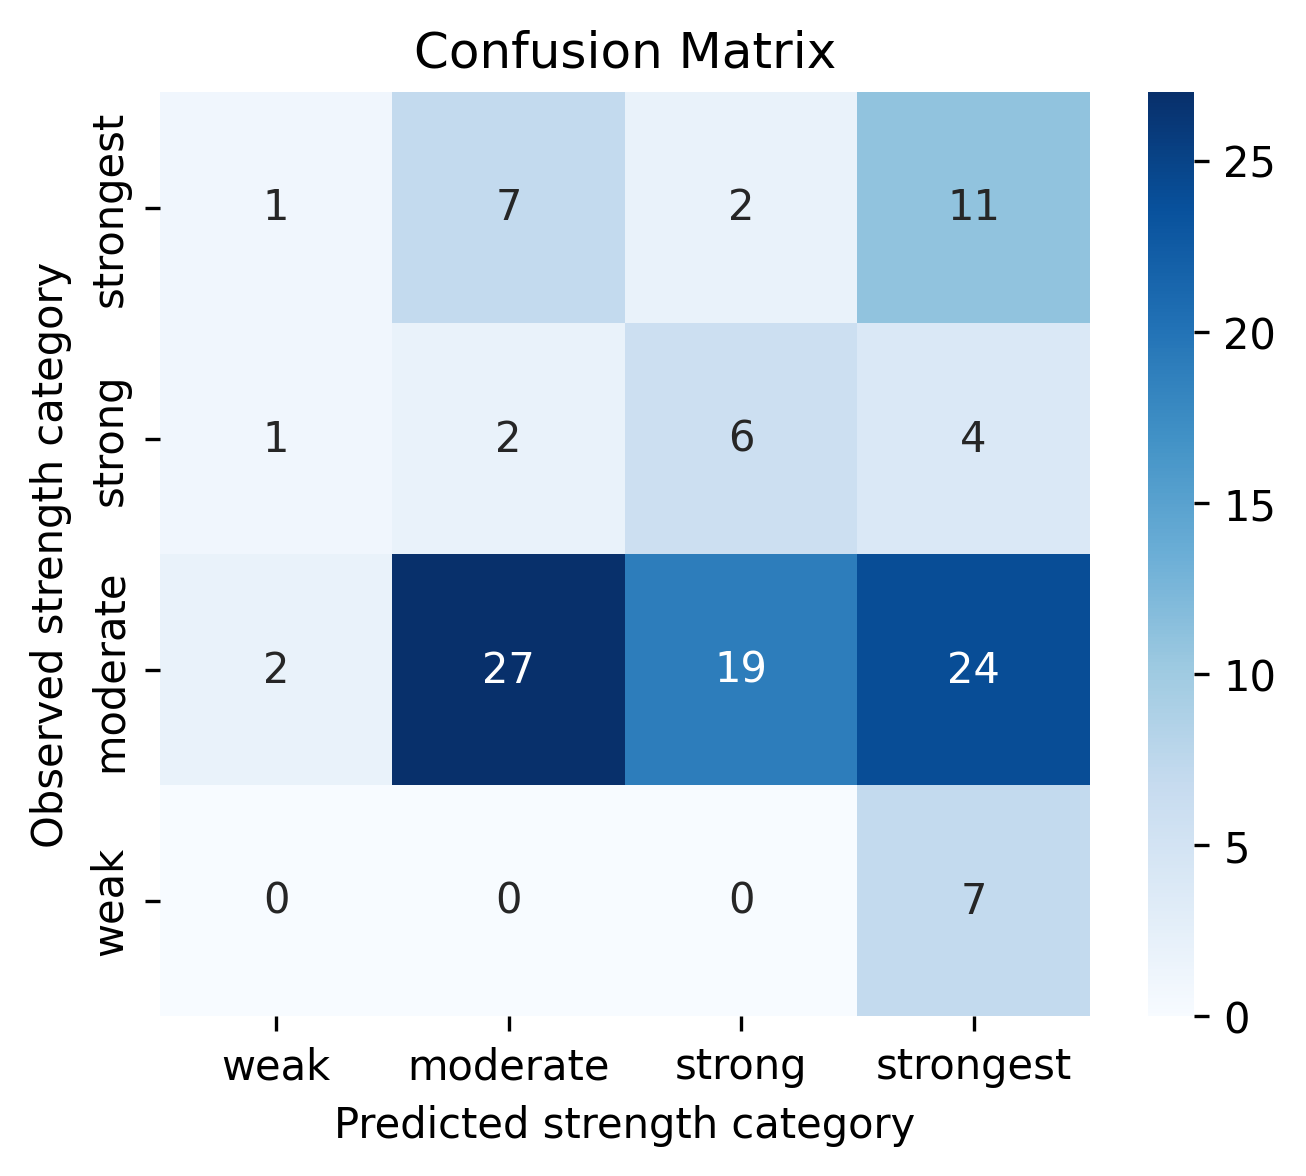

Classification Report for ratio_category:
              precision    recall  f1-score   support

        weak       0.07      0.50      0.12         4
    moderate       0.38      0.58      0.46        36
      strong       0.18      0.19      0.18        27
   strongest       1.00      0.02      0.04        46

    accuracy                           0.26       113
   macro avg       0.41      0.32      0.20       113
weighted avg       0.57      0.26      0.21       113



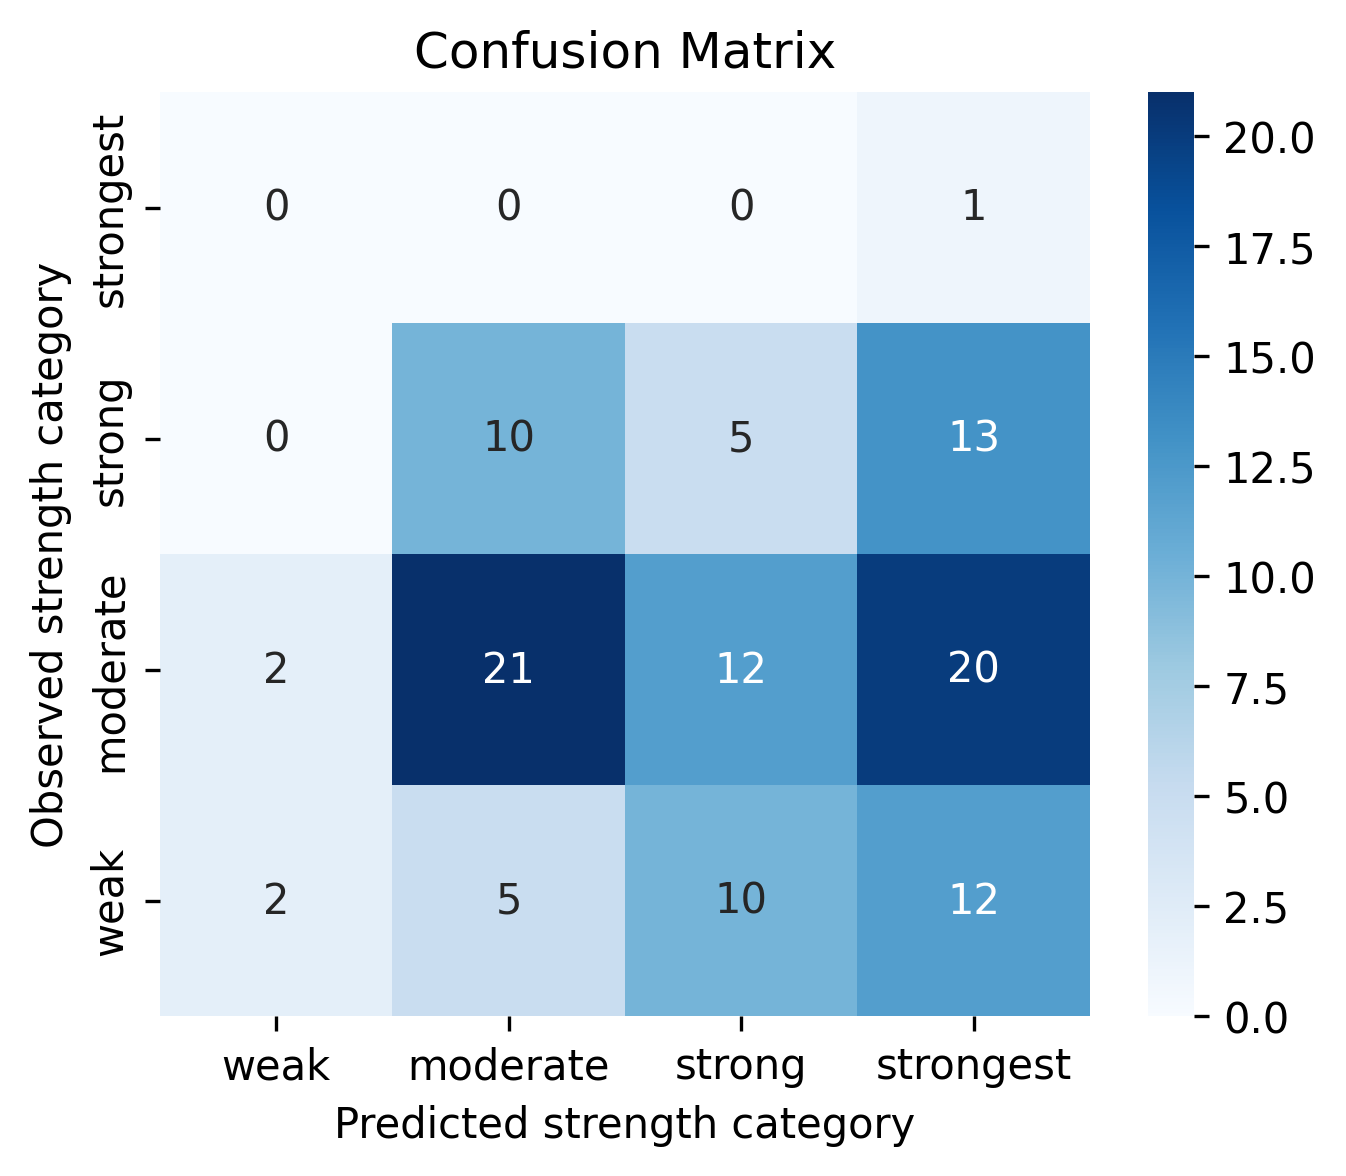

In [11]:
# Plotting subset confusion matrices
def plot_confusion_matrix( predicted_values, true_values, title):
    labels = ["weak", "moderate", "strong", "strongest"]
    matrix = confusion_matrix(true_values, predicted_values, labels=labels)
    plt.figure(figsize=(5, 4), dpi = 300)
    sns_heatmap = sns.heatmap(matrix, annot=True, fmt='d', cmap="Blues",
                              xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted strength category')
    plt.ylabel('Observed strength category')
    plt.title(title)
    sns_heatmap.invert_yaxis()  # Invert the Y axis to show 'strongest' at the top
    plt.show()

# Print classification report and plot confusion matrix for each category
for category in ['green_category', 'ratio_category']:   # other cataegories: 'rep_ratio_category', 'invert_rep_ratio_category'
    print(f"Classification Report for {category}:")
    print(classification_report(SynEAR_model['strength_class'], SynEAR_model[category], labels=["weak", "moderate", "strong", "strongest"]))
    plot_confusion_matrix(SynEAR_model['strength_class'], SynEAR_model[category], f"Confusion Matrix")

Permutation robustness check
Actual Model Accuracy: 0.3894
Permutation Test Mean/STD: 0.3091/0.0383
Std Devs Above Mean (Perm): 2.097404890572616
One-Tailed P-Value (Perm): 0.017978874266715978
Percent of permuted models we outperform: 98.2021125733284

Random prediction bootstrapping robustness check
Random Prediction Mean/STD: 0.3239/0.0421
Std Devs Above Mean (Random): 1.5529760921587605
One-Tailed P-Value (Random): 0.0602144231906645
Percent of boostrap models we outperform: 93.97855768093355


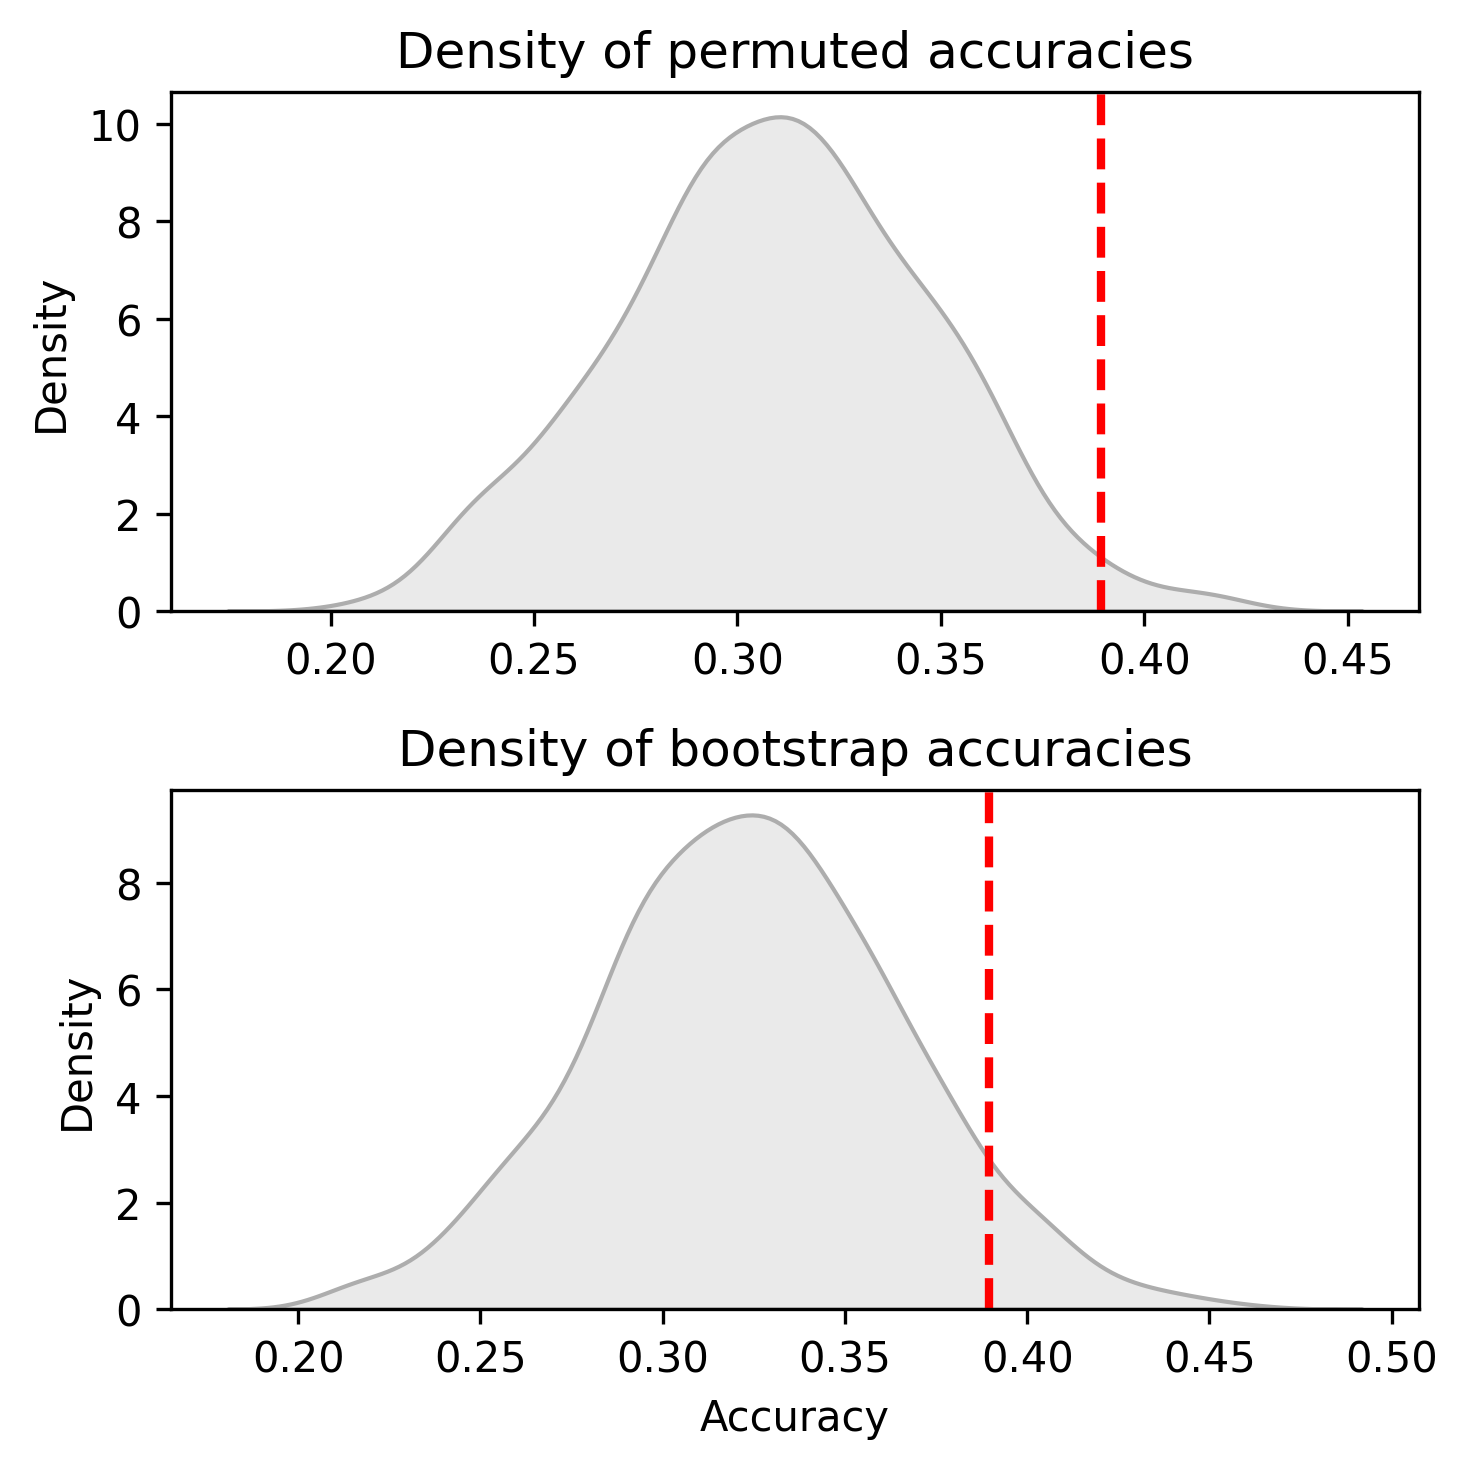

In [12]:
# Subset robustness checks and analysis
def permutation_test_accuracy(y_true, y_preds, n_permutations=1000):
    accuracies = []
    for _ in range(n_permutations):
        shuffled_labels = shuffle(y_true)
        accuracy = accuracy_score(shuffled_labels, y_preds)
        accuracies.append(accuracy)
    return accuracies

# Random predictions for comparison
def random_predictions_evaluation(y_true, n_iterations=1000):
    unique_classes = np.unique(y_true)
    probabilities = y_true.value_counts(normalize=True).reindex(unique_classes, fill_value=0).values
    bootstrap_accuracies = []
    for _ in range(n_iterations):
        random_preds = np.random.choice(unique_classes, size=len(y_true), p=probabilities)
        bootstrap_accuracies.append(accuracy_score(y_true, random_preds))
    return bootstrap_accuracies

# Common setup
actual_accuracy = accuracy_score(SynEAR_model['strength_class'], SynEAR_model['green_category'])

# Permutation test
accuracies_perm = permutation_test_accuracy(SynEAR_model['strength_class'], SynEAR_model['green_category'])
perm_mean = np.mean(accuracies_perm)
perm_std = np.std(accuracies_perm)
std_above_perm_mean = (actual_accuracy - perm_mean) / perm_std

# Random prediction test
bootstrap_accuracies = random_predictions_evaluation(SynEAR_model['strength_class'])
average_bootstrap_accuracy = np.mean(bootstrap_accuracies)
std_deviation = np.std(bootstrap_accuracies)
std_above_bootstrap_mean = (actual_accuracy - average_bootstrap_accuracy) / std_deviation

# Displaying results
print("Permutation robustness check")
print(f"Actual Model Accuracy: {actual_accuracy:.4f}")
print(f"Permutation Test Mean/STD: {perm_mean:.4f}/{perm_std:.4f}")
print(f"Std Devs Above Mean (Perm): {std_above_perm_mean}")
print(f"One-Tailed P-Value (Perm): {norm.sf(std_above_perm_mean)}")
print("Percent of permuted models we outperform:", 100 * (1 - norm.sf(std_above_perm_mean)))
print("")
print("Random prediction bootstrapping robustness check")
print(f"Random Prediction Mean/STD: {average_bootstrap_accuracy:.4f}/{std_deviation:.4f}")
print(f"Std Devs Above Mean (Random): {std_above_bootstrap_mean}")
print(f"One-Tailed P-Value (Random): {norm.sf(std_above_bootstrap_mean)}")
print("Percent of boostrap models we outperform:", 100 * (1 - norm.sf(std_above_bootstrap_mean)))

# Plots
fig, axes = plt.subplots(2, 1, figsize=(5, 5), dpi = 300)
sns.kdeplot(accuracies_perm, color='#adadad', fill=True, label='Permutation Distributions', ax=axes[0])
axes[0].axvline(x=actual_accuracy, color='red', linestyle='--', linewidth=2, label='Actual Model Accuracy')
axes[0].set_title('Density of permuted accuracies')
#axes[0].legend()

sns.kdeplot(bootstrap_accuracies, color="#adadad", fill=True, label='Bootstrap Distributions', ax=axes[1])
axes[1].axvline(x=actual_accuracy, color='red', linestyle='--', linewidth=2, label='Actual Model Accuracy')
axes[1].set_title('Density of bootstrap accuracies')
axes[1].set_xlabel('Accuracy')
axes[1].set_ylabel('Density')
#axes[1].legend()

plt.tight_layout()  # Adjust subplots to give some spacing
plt.show()
